# Saving Lives With Data: Reducing Number Of High Fatality Road Accidents

## Background
With humanity’s tremendous progress on road safety, regulation and enforcement, people still get injured and killed in road accidents. Our passion for free travel comes for a cost, measured in money terms and human life. Using data could further reduce casualty on the road and make everyone’s lives safer and more comfortable. In this report, we will try to establish major patterns in high-casualty road accidents that will help develop new measures for improving road safety. The research is based on a road accidents dataset in Great Britain in 2020.

*Data published by the department for transport: https://data.gov.uk/dataset/road-accidents-safety-data*

*Contains public sector information licensed under the Open Government Licence v3.0.*

⬇️⬇️ [Skip service code and jump directly to the story](#our-problem) ⬇️⬇️ 

#### Preparing environment

In [1]:
%%writefile requirements.txt
geopandas==0.10.2
ipykernel==6.0.3
ipython==7.26.0
ipython-genutils==0.2.0
ipywidgets==7.6.3
json5==0.9.6
jsonify==0.5
jsonpath-ng==1.5.3
jsonschema==3.2.0
jupyter-client==6.1.12
jupyter-core==4.7.1
jupyter-server==1.10.2
jupyterlab==3.1.4
jupyterlab-pygments==0.1.2
jupyterlab-server==2.6.2
jupyterlab-widgets==1.0.0
Markdown==3.3.4
markdown2==2.3.7
MarkupSafe==2.0.1
matplotlib==3.3.4
matplotlib-inline==0.1.2
notebook==6.4.1
numpy==1.21.4
oauthlib==3.1.1
openpyxl==3.0.7
pandas==1.3.4
pandas-datareader==0.10.0
pandasql==0.7.3
pandocfilters==1.4.3
regex==2021.8.3
scikit-learn==0.24.1
scipy==1.5.4
seaborn==0.11.1
statsmodels==0.12.2
urllib3==1.26.4

Overwriting requirements.txt


In [2]:
print('Installing packages...', end='')
!pip install -r requirements.txt &> /dev/null
print('done.')

Installing packages...done.


In [3]:
print('Importing packages...', end='')
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from matplotlib.patches import ArrowStyle, Ellipse, Rectangle
from matplotlib.ticker import AutoMinorLocator, FuncFormatter
import matplotlib.font_manager as font_manager

from IPython.display import Markdown, display

#from shapely.geometry import Point
print('done.')

Importing packages...done.


In [4]:
print('Installing fonts...', end='')
![[ ! -d "./fonts" ]] && mkdir fonts
![[ ! -f "./fonts/ArchivoNarrow\[wght\].ttf" ]] && wget -O ./fonts/ArchivoNarrow\[wght\].ttf https://github.com/google/fonts/raw/main/ofl/archivonarrow/ArchivoNarrow%5Bwght%5D.ttf &> /dev/null
![[ ! -f "./fonts/ArchivoNarrow-Italic\[wght\].ttf" ]] && wget -O ./fonts/ArchivoNarrow-Italic\[wght\].ttf https://github.com/google/fonts/raw/main/ofl/archivonarrow/ArchivoNarrow-Italic%5Bwght%5D.ttf &> /dev/null 
for font in font_manager.findSystemFonts('./fonts/'):
    font_manager.fontManager.addfont(font)
print('done.')

Installing fonts...done.


In [5]:
plt.rcParams['figure.figsize'] = [6, 3]
plt.rcParams['figure.dpi'] = 144
plt.rcParams['figure.facecolor']='#fff9f5'
plt.rcParams['figure.constrained_layout.use'] = True

plt.rcParams['axes.titlesize']=14
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['axes.titlepad']=12
plt.rcParams['axes.facecolor']='#fff9f5'

plt.rcParams['font.family'] = ['Archivo Narrow', 'Helvetica Narrow', 'PT Sans Narrow',
                               'Helvetica Neue', 'Sans', 'Arial Narrow', 'Arial']

COLORS = sns.color_palette()

In [6]:
print('Defining functions...', end='')
# HELPER FUNCTIONS

normalizer = lambda x: x/x.sum() # take Series

# Markdown format output
def printmd(string):
    display(Markdown(string))

PromilleFormatter = FuncFormatter(lambda x, y: '{:.1f}'.format(x*1000))

def connected_bars(data, ax=None, w=0.4, h=2, return_label_positions=False, alpha=0.1, title=None, cmap=COLORS):
    '''Each bars percentages must be in separate (2) rows,
    Each row - one bar, each column - a category.
    Example:
    data = df.groupby('time_bins').agg([np.mean, len])['major_accident'].apply(lambda x: x/x.sum())\
    .rename({'mean':'major_accidents', 'len':'accidents_count'}, axis=1).T
    (Note .T!)
    
    w - bar width (thickness)
    h - plot height'''
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,h))
    
    data.plot(kind='barh', stacked=True, width=w, ax=ax, color=cmap)
    
    dt0 = data.copy()
    dt0.insert(0, '0', 0)
    dt = dt0.cumsum(axis=1)

    for i in range(dt.shape[1]-1):
        x = [dt.iloc[0, i], dt.iloc[0, i+1], dt.iloc[1, i+1], dt.iloc[1, i]]
        y = [w/2, w/2, 1-w/2, 1-w/2]
        ax.fill(x,y, color=cmap[i], alpha=alpha)
        
    label_positions = ((dt0/2).shift(-1, axis=1)+dt)    
    
    for r in [0, 1]:
        for c in range(dt.shape[1]-1):
            ax.annotate('{:.1f}%'.format(data.iloc[r,c]*100), 
                        xy=(label_positions.iloc[r,c], r), 
                        c='w', ha='center', va='center', fontsize=8)

    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.axes.get_xaxis().set_visible(False)
    ax.yaxis.set_ticks_position('none')

    if ax.get_legend():
        ax.get_legend().remove()

    if title is not None:
        ax.get_figure().suptitle(title, color='#444444', fontsize=16, fontweight=600)
        
    if return_label_positions:
        return ax, label_positions 
    else:
        return ax   
    
    
def barplot_data_prep(df, metric):
    return df.groupby(metric, observed=True).agg([np.mean, len])['major_accident']\
    .apply(normalizer)\
    .rename({'mean':'Major accidents', 'len':'All accidents'}, axis=1).T


def ek_pointplot(df, metric, linex=None, 
                 ax=None, hue=None, sorter=None, color_labels=True, vr=0.4, title=None, CI=None, **kwargs):
    
    if linex is None:
        linex = baseline_rate
    
    GRADIENT = np.array([[0, 1]])
    
    if sorter is None:
        sorter = df[metric].unique()
    
    l = len(sorter)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,l*vr+0.5)) 
                 
    sns.pointplot(data=df, 
                  x='major_accident', y=metric, hue=hue, 
                  ax=ax, estimator=np.mean, join=False, orient='h', ci=90, 
                  dodge=0.2, 
                  palette=COLORS, 
                  order=sorter,
                 alpha=0.8, seed=4321, **kwargs)
    
    # we rely on autoscaling up until this point
    ax.set(autoscale_on=False)
    xlim = ax.xaxis.get_view_interval()
    ylim = ax.yaxis.get_view_interval()

    ax.imshow(GRADIENT, extent=(linex, xlim[1], ylim[0], ylim[1]), interpolation='bicubic',
                       vmin=0, vmax=1, alpha=0.2, aspect='auto', cmap='YlOrRd')

    ax.imshow(GRADIENT, extent=(linex, xlim[0], ylim[0], ylim[1]), interpolation='bicubic',
                       vmin=0, vmax=1, alpha=0.2, aspect='auto', cmap='YlGn')

    # baseline 
    ax.plot(2*[linex], ylim, linewidth=1, linestyle=':', color='gray')
    
    ax.annotate('Average major accident rate', 
                xy=(linex, ylim[1]),
                xytext=(0, 5), textcoords='offset pixels', 
                rotation='horizontal',
                fontsize=6,
                c='#444444',
               va='bottom', ha='center')
    
    if CI is not None:
        rec1 = Rectangle((CI[0], ylim[0] ), CI[1]-CI[0], ylim[1]-ylim[0], 
                         transform=ax.transData, lw=0, fill=False, alpha=0.1, ec='#000000', hatch='////////')
        ax.add_patch(rec1)
    
    ax.annotate('Safer', xy=(xlim[0],ylim[1]), 
                xytext=(10, -10), textcoords='offset pixels', 
                c='white', 
                fontsize=10, 
                bbox=dict(boxstyle="square", fc="green", lw=0, alpha=0.3),
                va='center', ha='left')

    ax.annotate('Danger zone', 
                xytext=(-10, -10), textcoords='offset pixels', 
                xy=(xlim[1],ylim[1]), 
                c='white', 
                fontsize=10, 
                bbox=dict(boxstyle="square", fc="maroon", lw=0, alpha=0.3),
               va='center', ha='right')

    if color_labels:
        [el.set_color((int(l/len(COLORS)+1)*COLORS)[n]) for n, el in enumerate(ax.yaxis.get_ticklabels())]
    
    ax.yaxis.set_ticks_position('none')
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.grid(True, which='minor', color='white', alpha=0.6)
    ax.yaxis.label.set_visible(False)
    ax.yaxis.set_tick_params(which='major', labelsize=10)

    ax.xaxis.set_label_text('Frequency of the accidents classified as major, per 1000 incidents', fontsize=9)
    ax.xaxis.set_major_formatter(PromilleFormatter)
    ax.xaxis.grid(True, which='major', color='white', alpha=0.6)
    
    if ax.get_legend():
        ax.get_legend().remove()

    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
    if title is not None:
        ax.get_figure().suptitle(title, color='#444444', fontsize=16, fontweight=600)
                    
    ax.annotate('Bars show 90% CI. Average major accident rate CI shaded', xy=(0,0), 
                xycoords='axes pixels', textcoords='offset pixels',
                xytext = (0,-80),
                fontsize=6, annotation_clip=False, fontstyle='italic', c='#666666')
    
    return ax


def double_plot(df, metric, axes=None, sorter=None, vr= 0.4, bar_width=0.6, **kwargs):
    
    if sorter is None:
        sorter = sorted(df[metric].unique().tolist())
    
    l = len(sorter)
    
    if axes is None:
        fig, axes = plt.subplots(1,2, figsize=(6,l*vr+1.0), gridspec_kw={'width_ratios': [2, 1]}) 
            
    #1
    axes[0].yaxis.tick_right()
    ek_pointplot(df, metric, ax=axes[0], linex=baseline_rate, sorter=sorter, **kwargs)
    
    #2
    sns.countplot(data=df[metric].astype('category').cat.remove_unused_categories().to_frame(), y=metric, 
                  orient='h', palette=COLORS, ax=axes[1], alpha=0.8, order=sorter)

    # custom bar thickness (directly change pathes)
    [i.set_height(bar_width) for i in axes[1].patches]
    [i.set_y(i.get_y()+(0.8-bar_width)/2) for i in axes[1].patches]
    
    # grid
    axes[1].xaxis.grid(True, which='major', color='#CCCCCC')
    axes[1].xaxis.set_ticks_position('none')
    axes[1].set_axisbelow(True)
    
    # remove plot box
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['bottom'].set_visible(False)
    axes[1].axes.get_yaxis().set_visible(False)

    axes[1].xaxis.set_label_text('Total number of accidents', fontsize=9)
    
    return tuple(axes)



def annotate(ax, annotation, datapoint, offset, position='bottom', rad=0.3):
    pos = {'bottom':['center','bottom'],
          'top':['center','top'],
          'left':['left','center'],
          'right':['right','center']}
    
    ax.annotate(annotation, xy=datapoint,
            xytext=offset, textcoords='offset pixels',
            c='#444444', 
            ha=pos[position][0], va=pos[position][1],
            fontstyle='italic', size=8,
            bbox=dict(boxstyle="square", fc="w", lw=0, alpha=0.6),
            arrowprops = dict(arrowstyle=ArrowStyle("->"),
                              connectionstyle='arc3, rad={:.1f}'.format(rad), color='#444444')
               )
    
    return ax

print('done.')

Defining functions...done.


#### Download and prepare data

In [7]:
print('Data reading and preparing...', end='')
accidents_data = pd.read_csv(r'./data/accident-data.csv', parse_dates = ['date', 'time'])
lookups = pd.read_csv(r'./data/road-safety-lookups.csv')

# replace number-coded categories with strings and then convert to factors
lookup_columns = lookups.dropna(axis=0, subset=['label'])['field name'].drop_duplicates().tolist()
lookup_columns = set(lookup_columns)-{'first_road_number', 'second_road_number', 'speed_limit'}

lookup_dictionary = {column_name: 
                             {  int(row[r"code/format"]): row["label"] 
                                for _, row in lookups[lookups['field name']==column_name].iterrows()
                              }
                     for column_name in lookup_columns
                    }

df = accidents_data.replace(lookup_dictionary)\
    .astype({key:'category' for key in lookup_dictionary.keys()})
print('done.')

Data reading and preparing...done.


In [8]:
# Adding extra features
# Label: major accident = Fatal with >=3 casualties
df['major_accident'] = df.apply(
    lambda row: row["accident_severity"]=='Fatal' and row["number_of_casualties"]>=3, 
    axis=1)

# Casualties binned: 1, 2, 3+
df['number_of_casualties_aggregated'] = df['number_of_casualties']\
    .map(lambda value: "3+" if value>=3 else str(value)).astype('category') 

# Make categories properly ordered
df['accident_severity'] = df['accident_severity'].cat\
    .reorder_categories(['Slight', 'Serious', 'Fatal', ], ordered = True)

# speed binned
speed_bins = {20: '20-30',
             30: '20-30',
             40: '40-50',
             50: '40-50',
             60: '60-70',
             70: '60-70',
             -1: None}
df['speed_limit_bins'] = df.speed_limit.replace(speed_bins).astype('category').cat.as_ordered()

time_of_day_bins = ['Night (0-6am)', 'Morning (6-12pm)', 'Afternoon (12-18)', 'Evening (18-24)']
df['time_bins'] = df['time'].dt.hour.map(lambda h: time_of_day_bins[int(h/6)])\
    .astype('category').cat.reorder_categories(time_of_day_bins, ordered=True)

## Our Problem
We are trying to discover ways to reduce the numbers and severity of the most serious road accidents in Great Britain from detailed data about the accidents in 2020.

The data shows that in 2020 in Great Britain, there were 91,199 road accidents in total, including 71,453 slight, 18,355 serious and 1391 fatal (fig. below). In all of these, 115,584 casualties were involved.

We technically define a _major accident_ as a fatal one with 3+ casualties. In 2020 there were 202 accidents in this category. In other words, significant occurrences happen on average with the rate of 2.2 per 1000 accidents — we will use this number as a baseline for further comparisons. 

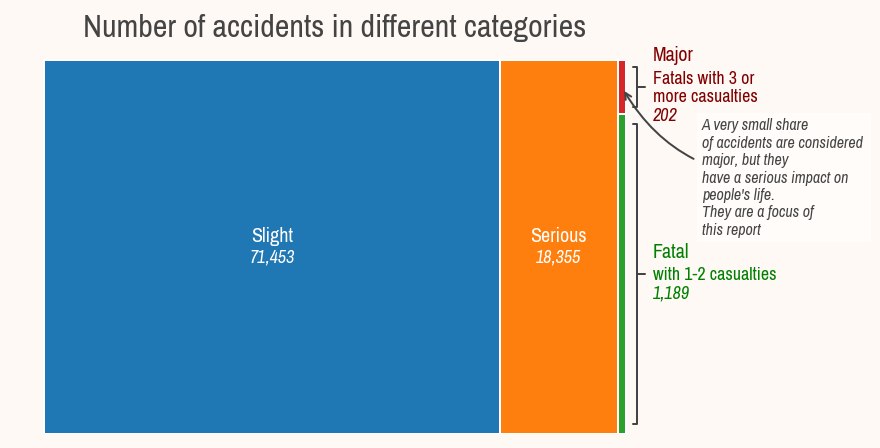

In [35]:
# First plot - treemap style to overview total numbers

boxes_s = [0] + df.groupby(['accident_severity']).count().iloc[:,0].loc[['Slight', 'Serious']].tolist()

boxes_f = df.query('accident_severity == "Fatal"')\
    .groupby(['major_accident']).count().iloc[:,0].tolist()

boxes_f_n = [x/sum(boxes_f) for x in boxes_f] # normalize

# plotting
fig, ax = plt.subplots()

# draw first two boxes
p1 = ax.bar(x=boxes_s[0:2], 
            width=boxes_s[1:], height=1, 
            align='edge', color=COLORS, edgecolor='white')

# two last boxes ('fatals')
p2 = ax.bar(x=sum(boxes_s), 
            width=sum(boxes_f), height=boxes_f_n, bottom = [0, boxes_f_n[0]], 
            align='edge', color=COLORS[2:], edgecolor='white')

ax.annotate('Slight\n', xy=(boxes_s[1]/2, 0.5), ha='center', va='center', 
            c='white', fontweight='bold', size=10)
ax.annotate('\n{:,}'.format(boxes_s[1]), 
            xy=(boxes_s[1]/2, 0.5) , ha='center', va='center', 
            c='white', fontstyle='italic', size=9)

ax.annotate('Serious\n', 
            xy=(boxes_s[1]+boxes_s[2]/2, 0.5), ha='center', va='center',  
            c='white', fontweight='bold', size=10)
ax.annotate('\n{:,}'.format(boxes_s[2]), 
            xy=(boxes_s[1]+boxes_s[2]/2, 0.5), ha='center', va='center', 
            c='white', fontstyle='italic', size=9)

ax.annotate('Fatal\n\n', xy=(sum(boxes_s+boxes_f)+1000, boxes_f_n[0]/2), 
            xytext=(20, 0), textcoords='offset pixels',
            c='green', ha='left', va='center', 
            arrowprops = dict(arrowstyle=ArrowStyle("-[", widthB=7.5, lengthB=0.2, angleB=0), 
                              connectionstyle='angle', color='#444444'),
            fontweight='bold', size=10)

ax.annotate('\nwith 1-2 casualties\n', xy=(sum(boxes_s+boxes_f)+1000, boxes_f_n[0]/2), xytext=(20, 0),
            textcoords='offset pixels', c='green', ha='left', va='center', 
            size=9)
ax.annotate('\n\n{:,}'.format(boxes_f[0]), xy=(sum(boxes_s+boxes_f)+1000, boxes_f_n[0]/2), 
            xytext=(20, 0), textcoords='offset pixels', c='green', ha='left', va='center', 
           fontstyle='italic', size=9)

ax.annotate('Major\n\n\n', xy=(sum(boxes_s+boxes_f)+1000, boxes_f_n[0]+boxes_f_n[1]/2), 
            xytext=(20, 0),
            textcoords='offset pixels',
            c='maroon', ha='left', va='center', 
            arrowprops = dict(arrowstyle=ArrowStyle("-[", widthB=1, lengthB=0.2, angleB=0), 
                              connectionstyle='angle', color='#444444'),
            fontweight='bold', size=10)

ax.annotate('\nFatals with 3 or\nmore casualties\n', xy=(sum(boxes_s+boxes_f)+1000, boxes_f_n[0]+boxes_f_n[1]/2), 
            xytext=(20, 0),
            textcoords='offset pixels',
            c='maroon', ha='left', va='center', 
            size=9)

ax.annotate('\n\n\n{:,}'.format(boxes_f[1]), xy=(sum(boxes_s+boxes_f)+1000, boxes_f_n[0]+boxes_f_n[1]/2), 
            xytext=(20, 0), textcoords='offset pixels',
            c='maroon', ha='left', va='center', 
            fontstyle='italic', size=9)

ax.set_title('Number of accidents in different categories', color='#444444', pad=0, fontsize=16, fontweight=600)

annotation = '''A very small share
of accidents are considered 
major, but they
have a serious impact on
people's life.
They are a focus of
this report'''

annotate(ax, annotation, (sum(boxes_s)+sum(boxes_f)/2, boxes_f_n[0]+boxes_f_n[1]/2), 
         (80, -90), position='left', rad=-0.3)

plt.axis('off')

plt.show()

In [10]:
# Average rate at which major accidents happen - around 0.2% of all accidents. We will use it for comparison.
baseline_rate = df.query('major_accident').shape[0]/df.shape[0] 

summary_statictics = dict(
    n_accidents=df.shape[0], 
    sum_casualties=df['number_of_casualties'].sum(),
    n_fatal_accidents=df.query('accident_severity == "Fatal"').shape[0],
    major_accidents=df.query('major_accident').shape[0],
    major_accidents_rate=baseline_rate*1000,
    avg_casualty=df['number_of_casualties'].mean(),
    avg_casualty_major=df.query('major_accident')['number_of_casualties'].mean()
)


printmd('''
|Summary statistics| |
|:-|-:|
|Total number of accidents |{n_accidents}|
|Total number of casualties |{sum_casualties}|
|Fatal accidents |{n_fatal_accidents}|
|- inc. major accidents| {major_accidents}|
|Average major accidents rate (per 1000 accidents)| {major_accidents_rate:.2f}|
|Average number of casualties| {avg_casualty:.2f}|
|Average number of casualties in a major accident| {avg_casualty_major:.2f}|'''\
      .format(**summary_statictics)
     )


|Summary statistics| |
|:-|-:|
|Total number of accidents |91199|
|Total number of casualties |115584|
|Fatal accidents |1391|
|- inc. major accidents| 202|
|Average major accidents rate (per 1000 accidents)| 2.21|
|Average number of casualties| 1.27|
|Average number of casualties in a major accident| 3.73|

In [36]:
%%capture _
fx, ax = plt.subplots(1, figsize=(0.2,0.2))
ek_pointplot(df.dropna(), 'accident_year', sorter=None,
               ax=ax, title='Countries', vr=0.1, n_boot=1000)
ax.get_figure().set_visible(False)

CI = ax.lines[0].get_xdata() # Use sns bootstrapping backend to get CI fast 

## Diggin Deeper: Does Speed Kill?
So what are the key factors driving the severity of road accidents up? Let’s look at the data.

The most apparent theory to start with would be, probably, the impact of higher speeds. We know a car accident outcome worsens significantly as the speed of the vehicle rises.

Data shows that while less than 18% of reported accidents happen on roads with a speed limit of 60 mph and over, more than half of major accidents are attributed to such roads. Overall, accidents on high-speed roads end up as a major event in 7.3‰ cases — the rate being 3.3 times higher than average.

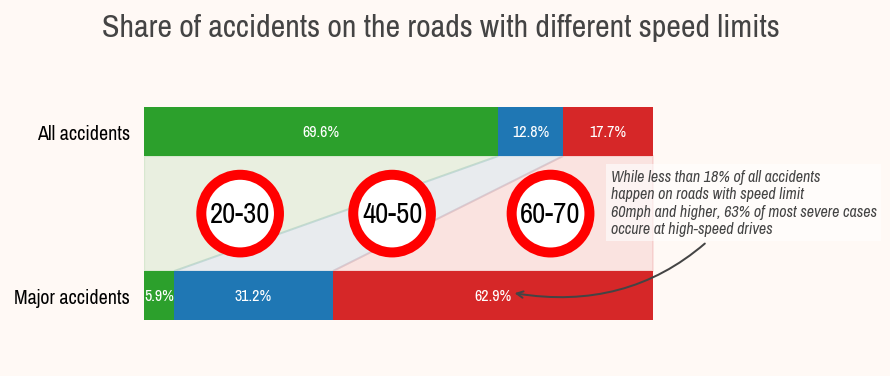

In [12]:
plotting_data = barplot_data_prep(df, 'speed_limit_bins')

ax, pos = connected_bars(plotting_data, w=0.3, h=2.5, title='Share of accidents on the roads with different speed limits',
              return_label_positions=True, cmap=[COLORS[2]]+[COLORS[0]]+[COLORS[3]])

[ax.annotate(txt, xy=(x, 0.5),
             bbox=dict(boxstyle="circle", fc="w", ec='r', lw=5),
                   size='x-large', fontweight='bold',
            va='center', ha='center',
           color='black',
            annotation_clip=False) 
 for txt, x in pos.mean().shift(1).dropna().iteritems()]

annotation =\
'''While less than 18% of all accidents 
happen on roads with speed limit 
60mph and higher, 63% of most severe cases
occure at high-speed drives'''

annotate(ax, annotation, (0.72,0.02), 
         (100, 90), position='left', rad=-0.3)

plt.show()

We would, of course, expect that higher speed on the road automatically means more severe outcomes. However, worth noting that the rate of major accidents is lower for roads with a speed limit of 70 mph at 5.1‰ (with that of 60 mph being 8.2‰). The roads with a 70 mph speed limit are mostly dual carriage motorways (featuring a central divider and other enhanced safety features), making them remarkably safer than single carriageways. Single carriageway roads account for ~90% of roads with a 60mph limit. High-speed parts of the single carriageway network encounter the rate of major accidents is at its highest at more than 8‰.

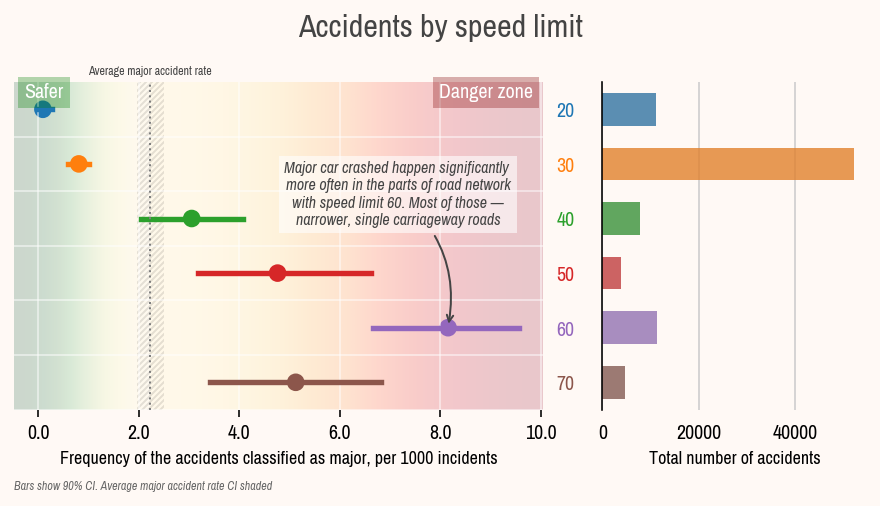

In [13]:
ax = double_plot(df.query('speed_limit!=-1'), 'speed_limit', 
                 title='Accidents by speed limit', color_labels=True, CI=CI)

annotation = '''Major car crashed happen significantly 
more often in the parts of road network
with speed limit 60. Most of those —
narrower, single carriageway roads'''

annotate(ax[0], annotation, (0.00815, 4), 
         (-50, 100), position='bottom', rad=-0.3)

plt.show()



Considering the above, no surprise that the major accident frequency depends on the location of the accident — if it happens within or out of city limits. Roads/streets in urban areas tend to have lower speed limits of 20-30mph. Subsequently, we would expect that the frequency of major accidents in rural areas is higher than within city boundaries. The data confirms it: while 68% of all accidents happen in urban areas (reflecting a higher density of traffic there), only 13% of the _major_ accidents happen in the city.

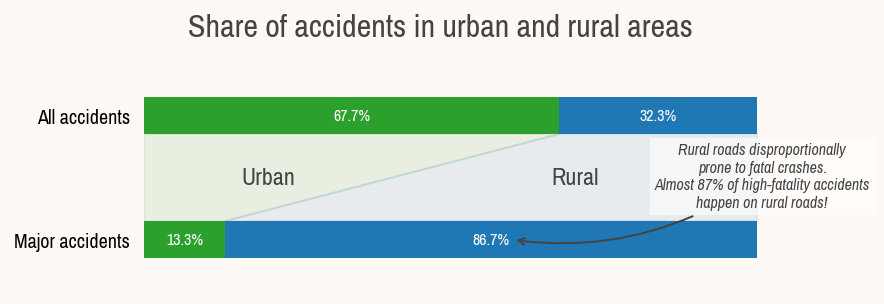

In [14]:
plotting_data = barplot_data_prep(df.query("urban_or_rural_area != 'Unallocated'"), 'urban_or_rural_area')

ax, pos = connected_bars(plotting_data, w=0.3, h=2, title='Share of accidents in urban and rural areas',
              return_label_positions=True, cmap=[COLORS[2]]+[COLORS[0]]+[COLORS[3]])

[ax.annotate(txt, xy=(x, 0.5),
                size='large', 
            va='center', ha='center',
           color='#444444',
            annotation_clip=False) 
 for txt, x in pos.mean().shift(1).dropna().iteritems()]

annotation =\
'''Rural roads disproportionally
prone to fatal crashes.
Almost 87% of high-fatality accidents
happen on rural roads!'''
annotate(ax, annotation, (0.60,0), (250, 30), rad=-0.2)

plt.show()

The rate of these major accidents in rural areas reaches 5.2 per mille, which 6.5 higher than in the populated areas. While all in all number of accidents in urban areas is more that teo times higher, number of fatal crashes and casualties higher for the accidents happening on the countriside (or, to be precise, intercity highways).

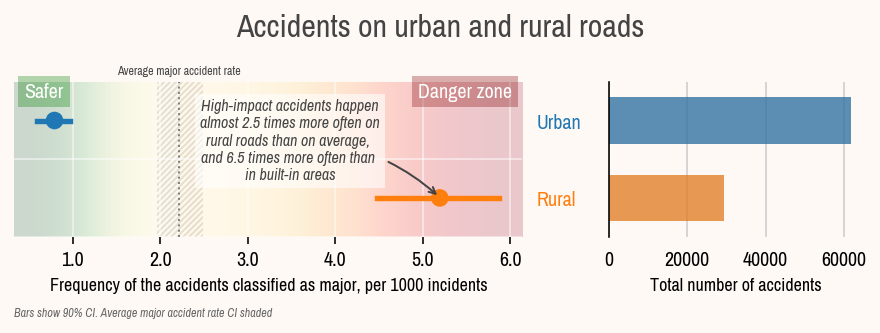

In [15]:
df_temp = df.query('urban_or_rural_area != "Unallocated"')

sorter = df_temp.groupby('urban_or_rural_area', observed=True)\
    .count().sort_values('accident_index', ascending=False).index.tolist()

axes = double_plot(df_temp, 'urban_or_rural_area', 
                  sorter=sorter, title='Accidents on urban and rural roads', 
                   vr=0.6, CI=CI)

annotation =\
'''High-impact accidents happen
almost 2.5 times more often on
rural roads than on average, 
and 6.5 times more often than 
in built-in areas'''
annotate(axes[0], annotation, (0.0052,1), (-150, 15), rad=-0.2)

plt.show() 

#df.groupby(['urban_or_rural_area','accident_severity']).agg(['count', 'mean'])['number_of_casualties']

## Junction Dread
It may be expected that junctions “attract” road accidents because crossing traffic make junctions more challenging zones for drivers. It is true. The chances of getting into an accident at an intersection are high — in fact, almost 57% of all accidents happen at a junction. However, considering the fatality of these accidents, we will see that the most severe accidents typically happen not at a junction. 69% of incidents occur not within a vicinity of an intersection. The rate of major accidents at a junction is 1.2 per mille (below average), while away from a junction this rate is 3.7‰.

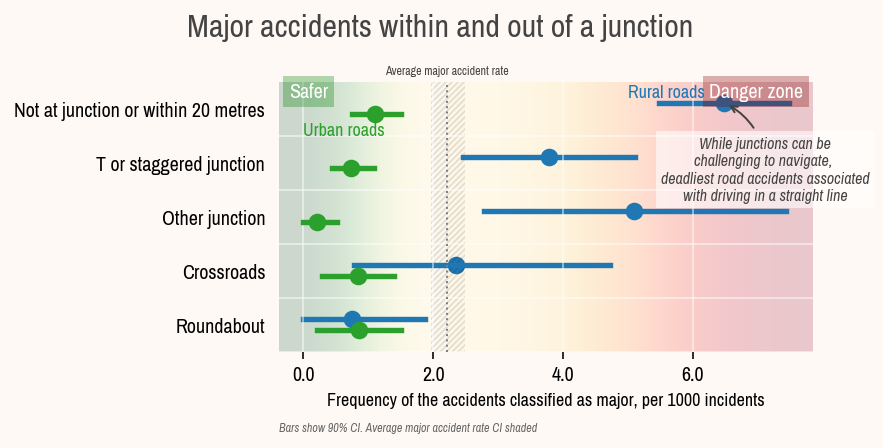

In [16]:
# bin some small intersections categories
junctions_other_bin = [ 'Data missing or out of range',
                  'Mini-roundabout', 'More than 4 arms (not roundabout)',
                  'Other junction',
                  'Private drive or entrance', 'Slip road',
                  'unknown (self reported)'] 

junction_binner = {i: 'Other junction' for i in junctions_other_bin}


plotting_data = df.query('urban_or_rural_area != "Unallocated"').replace({'junction_detail': junction_binner})

sorter = plotting_data.groupby('junction_detail', observed=True).count().sort_values('accident_index', ascending=False).index.tolist()

ax = ek_pointplot(plotting_data, 'junction_detail', 
                  hue='urban_or_rural_area', sorter=sorter,
                  color_labels=False,
                  title='Major accidents within and out of a junction',
                  vr=0.5, CI=CI)

ax.annotate('Rural roads', xy=(0.005,-0.22), size=9, c=COLORS[0])
ax.annotate('Urban roads', xy=(0.0000,0.5), size=9, c=COLORS[2])

annotation =\
'''While junctions can be
challenging to navigate, 
deadliest road accidents associated
with driving in a straight line'''

annotate(ax, annotation, (0.0065,-0.1), (40, -100))

plt.show() 

## Dark Riders
The accident count varies significantly according to the time of the day, with the highest numbers of cases in the morning and afternoon, when people commute to work and go around on business, and lower numbers at night.

However, the distribution of high-casualty accidents over hours is quite different. A disproportionate number of accidents with higher fatalities happen in the evening and at night. In particular, only 5% of all accidents happen at night/early morning between 12 and 6am, when there are not many cars on the road. However, these cars get into severe accidents three times more often. Up to 16% of significant accidents happen between 12 and 6am.

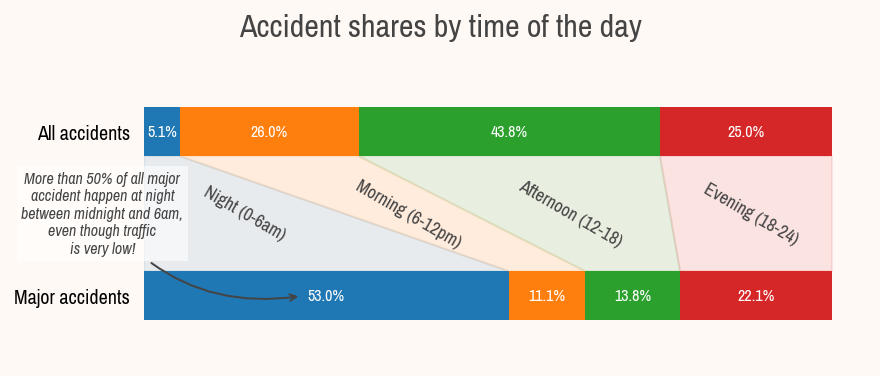

In [17]:
plotting_data = barplot_data_prep(df, 'time_bins')

ax, pos = connected_bars(plotting_data, w=0.3, h=2.5, title='Accident shares by time of the day',
              return_label_positions=True, )

[ax.annotate(txt, xy=(x, 0.5),
                size=9, rotation=-30,
            va='center', ha='center',
           color='#444444',
            annotation_clip=False) 
 for txt, x in pos.mean().shift(1).dropna().iteritems()]

annotation =\
'''More than 50% of all major
accident happen at night
between midnight and 6am,
even though traffic
is very low!'''
annotate(ax, annotation, (0.23,0),(-200,40))

plt.show()

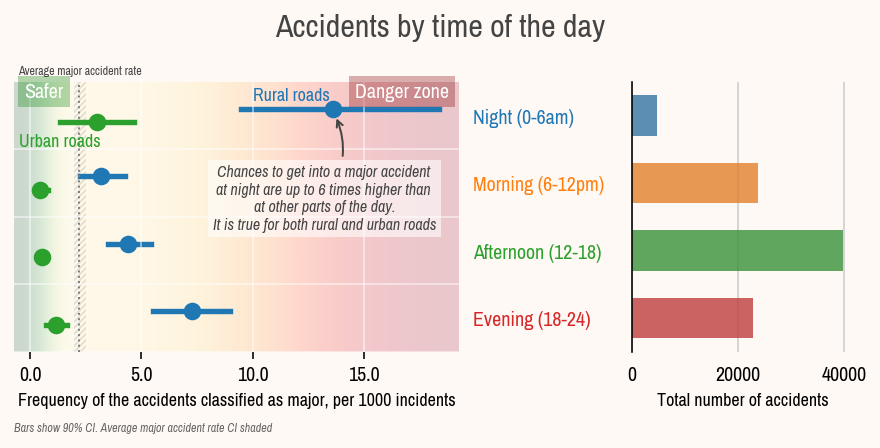

In [18]:
df_filtered = df.query('urban_or_rural_area != "Unallocated"')

ax = double_plot(df_filtered, 'time_bins', hue='urban_or_rural_area', sorter=time_of_day_bins,
                 title='Accidents by time of the day', vr=0.5, CI=CI)

# Annotations
ax[0].annotate('Rural roads', xy=(0.010,-0.22), size=9, c=COLORS[0])
ax[0].annotate('Urban roads', xy=(-0.0005,0.45), size=9, c=COLORS[2])

annotation = \
'''Chances to get into a major accident 
at night are up to 6 times higher than 
at other parts of the day.
It is true for both rural and urban roads'''
annotate(ax[0], annotation, (0.0137,-0.01), (-10,-50), position='top', rad=0.3)

plt.show() 

We can contemplate a few reasons for that, both environmental and behavioural. Generally being more challenging, driving in the dark may be one of them. On the other hand, behavioural factors such as impaired driving, speeding, and drivers’ fatigue (the aspects we would expect showing some time-of-the-day pattern) might be at work here.

We can check if indeed the light conditions make driving much more dangerous. If the darkness is the main factor, we would expect that accidents on the parts of the road with artificial illumination would show much better outcomes in terms of casualties.

Numbers support this hypothesis — the rate of major accidents in rural areas with no artificial lighting is significantly higher than in illuminated stretches. So, driving in the dark worsens outcomes for road collisions.

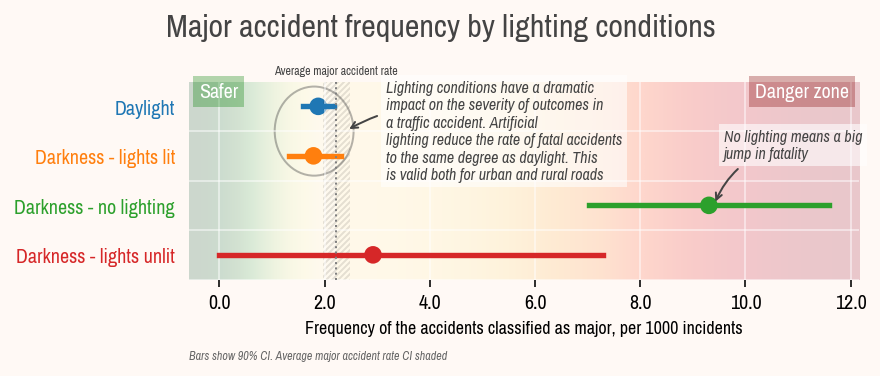

In [19]:
df_filtered = df.query('light_conditions in ("Darkness - lights lit", "Darkness - lights unlit", "Darkness - no lighting", "Daylight")')

sorter = df_filtered.groupby('light_conditions', observed=True).count().sort_values('accident_index', ascending=False).index.tolist()

ax = ek_pointplot(df_filtered, 'light_conditions', sorter=sorter,
                 title='Major accident frequency by lighting conditions', vr=0.5, CI=CI)

#annotations
circle1 = Ellipse((0.0018, 0.5), 0.0015, 1.8, transform=ax.transData, fill=False, ec='#444444', alpha=0.4 )
ax.add_patch(circle1)

annotation1 =\
'''Lighting conditions have a dramatic 
impact on the severity of outcomes in 
a traffic accident. Artificial
lighting reduce the rate of fatal accidents
to the same degree as daylight. This
is valid both for urban and rural roads'''

annotation2 = '''No lighting means a big
jump in fatality'''

annotate(ax, annotation1, (0.0024, 0.5), (40,0), position='left')
annotate(ax, annotation2, (0.0094, 2), (10,60), position='left')

plt.show() 

All in all, the rate of major accidents is at its highest between 3 and 6am — we can suggest that fatigue might contribute to these numbers. Another peak of big crashes is at 10pm — those might be the ‘party’ related accidents. Weekend accidents peak on Saturday evening and drop to their lowest for Monday early morning.

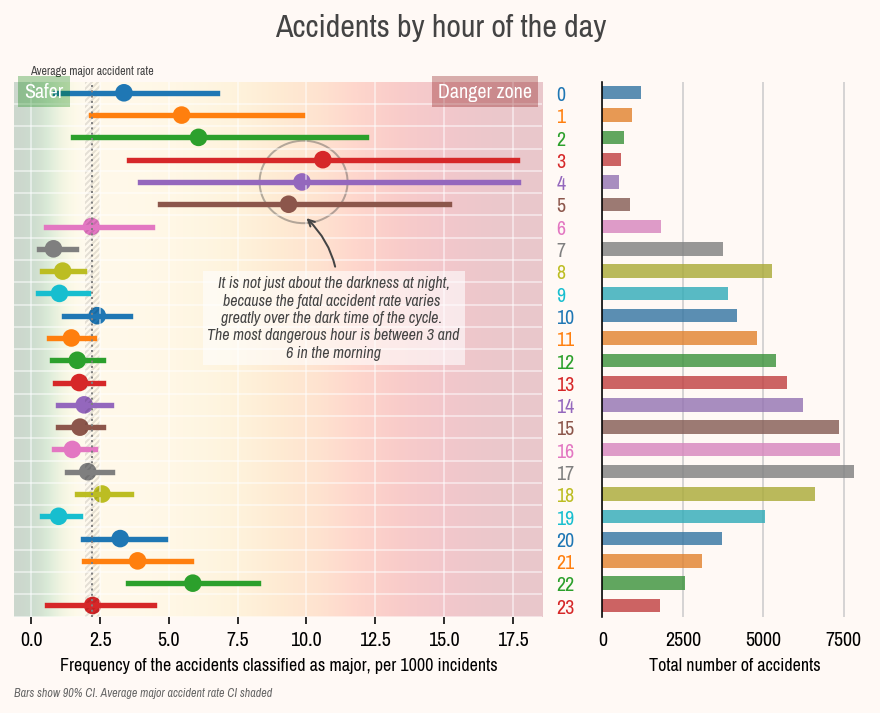

In [20]:
df = df.assign(hour=df.time.dt.hour)

axes = double_plot(df, 'hour', 
                   sorter=list(range(0, 24)),
                   vr=0.16, 
                   title='Accidents by hour of the day', CI=CI)

annotation =\
'''It is not just about the darkness at night,
because the fatal accident rate varies 
greatly over the dark time of the cycle. 
The most dangerous hour is between 3 and
6 in the morning'''

annotate(axes[0], annotation, (0.0099, 5.5), (30,-60), position='top')
         
circle1 = Ellipse((0.0099, 4), 0.0032, 3.7, transform=axes[0].transData, fill=False, ec='#444444', alpha=0.4 )
axes[0].add_patch(circle1)
         
plt.show()

What about “behavioural” factors? The data does not provide inputs to assess the behavioural hypothesis, including drinking and speeding. If such factors are at play, we would probably see a distinct day-of-the-week pattern with more deadly night accidents happening on weekends.

Indeed, we see an increase in the major accident rate in the evenings on Saturdays (the plot is not shown here), which can support a hypothesis that on weekends people drive more recklessly on weekend nights. However, there is not enough data to conclude — for instance, Friday stays stable while Saturday evenings see more deadly accidents.

Anyway, on average, days of the week differ on their accident numbers. Thursday is the busiest day of the week and has the highest number of accidents. However, most major accidents happen on Saturday, with Thursdays having only the third-highest rate of the major accidents after Sunday. The  accidents in question on weekends are twice as often as on weekdays (3.6‰ vs 1.6‰)

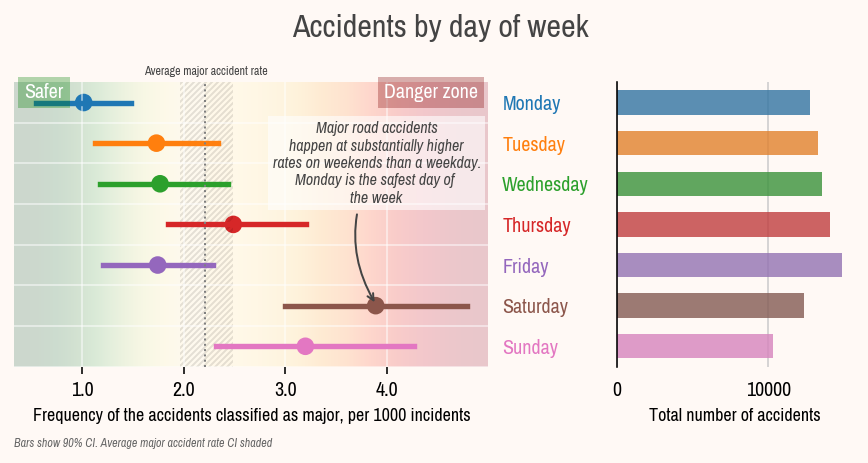

In [21]:
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

axes = double_plot(df, 'day_of_week', sorter=sorter,
                vr=0.3, 
               title='Accidents by day of week', CI=CI)

annotation =\
'''Major road accidents
happen at substantially higher
rates on weekends than a weekday.
Monday is the safest day of 
the week'''

annotate(axes[0], annotation, (0.0039, 5), (0,100))

plt.show()

## Long Winter Nights

Does a longer winter night mean more fatal accidents in winter? Not exactly! Within a year, the most dangerous month is, surprisingly, August. Usually sporting fair weather and long days, August attracted 13.4 per cent of major accidents in 2020 (with the rate of 3.3‰ — almost twice that in July and three times higher than the safest month of May). One of the explanations might be that at the peak of the holiday season, more people are on the move (including some inexperienced drivers) travelling longer distances. The week before the 1st of September is more major accidents happen than in any other week of the year.

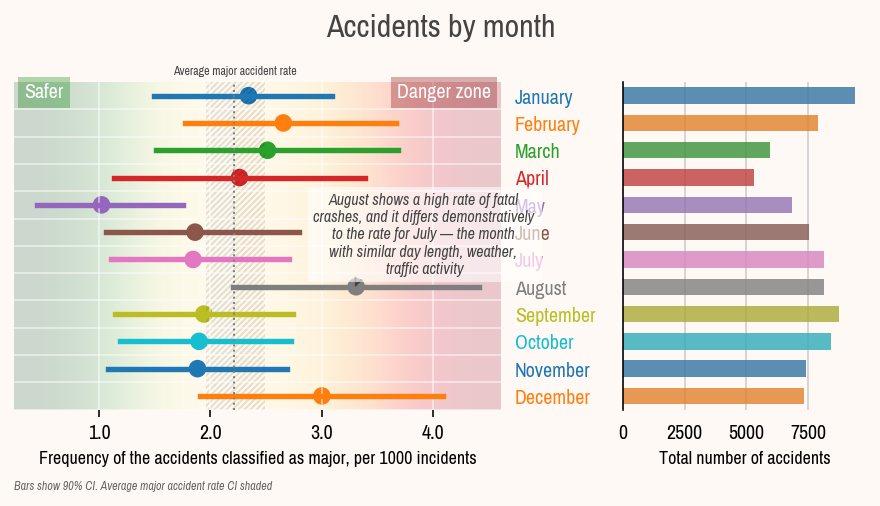

In [22]:
df = df.assign(month=df.date.dt.month_name())

sorter = pd.date_range(start='2020-01', freq='M', periods=12).month_name().tolist()

ax, _ = double_plot(df, 'month', sorter=sorter,
                title='Accidents by month',
                  vr=0.2, CI=CI)

annotation=\
'''August shows a high rate of fatal 
crashes, and it differs demonstratively 
to the rate for July — the month 
with similar day length, weather, 
traffic activity'''
annotate(ax, annotation, (0.0033, 7), (70,10))

plt.show()

Nevertheless, the second-highest rate of major accidents is December, which supports the version about more challenging driving conditions in winter.

The hypothesis is that snow and rain may contribute to higher severity of outcomes. Generally, more traffic accidents of all levels happen in winter, with the January accident number being the highest in the year. However, it does not affect the rate of high-fatality accidents that much, with the January rate being pretty average.

We can look at different seasonal factors, such as shorter daylight, temperatures (especially temperatures around 0), slippery roads and visibility issues. Analysis shows that while raining and snowing as a visibility factor do not affect fatality of accidents at a statistically significant level, the road surface conditions do. Wet road contributes to a higher percentage of major accidents

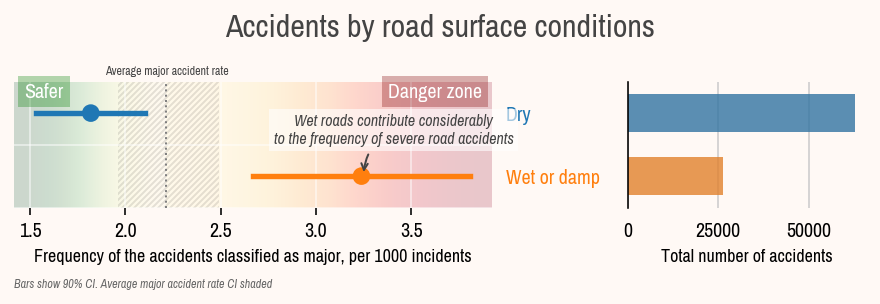

In [23]:
df_filtered = df.query('road_surface_conditions in ("Dry","Wet or damp")')

ax, _ = double_plot(df_filtered, 'road_surface_conditions', sorter=["Dry","Wet or damp"],
                vr=0.5, title='Accidents by road surface conditions', CI=CI)

annotation=\
'''Wet roads contribute considerably
to the frequency of severe road accidents'''

annotate(ax, annotation, (0.00325, 1), (30,30))

plt.show()

## Bad Neighbourhoods

Finally, let us look at the numbers from a geographical point of view. Is there patterns over different locations, countries and counties?

⬇️⬇️ [Skip code, read story on](#big-picture-countries) ⬇️⬇️

#### Geospatial Data Prep

In [24]:
print('Downloading geospatial data..', end='')
![[ ! -d "./geo_data" ]] && mkdir geo_data
![[ ! -f "./geo_data/ne_10m_admin_1_states_provinces.zip" ]] && wget -O ./geo_data/ne_10m_admin_1_states_provinces.zip\
 https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_1_states_provinces.zip  &> /dev/null
!unzip -qu ./geo_data/ne_10m_admin_1_states_provinces.zip -d ./geo_data
print('ready')

In [25]:
uk_counties = gpd.read_file('./geo_data/ne_10m_admin_1_states_provinces.dbf').query("iso_a2=='GB'")
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs="EPSG:4326")

def extract_geodata(row):
    none_result = {'country': None, 'county': None}
    if pd.isna(row['longitude']) or pd.isna(row['latitude']):
        return none_result

    global apply_progress
    
    if apply_progress % 10000 == 0:
        print('\n', apply_progress, end='')
    
    if apply_progress % 200 == 0:
        print('.', end='')
    
    apply_progress-=1
    
    place = uk_counties[uk_counties.intersects(row.geometry.buffer(0.002))]
    if len(place)>0:
        county = place.loc[:,'name'].iloc[0]
        country = place.loc[:,'geonunit'].iloc[0]
        return {'country': country, 'county': county}
    else:
        return none_result
    
    
    
apply_progress=len(gdf)
print('Matching geodata. Records to match:\n', apply_progress, end='')

topo_names = gdf.apply(extract_geodata, axis=1, result_type='expand')

df = df.join(topo_names)

Matching geodata. Records to match:
 91199.....
 90000..................................................
 80000..................................................
 70000..................................................
 60000..................................................
 50000..................................................
 40000..................................................
 30000..................................................
 20000..................................................
 10000..................................................

### Big Picture: Countries

The data shows information for three regions of the UK (Northern Ireland is not included). As the most populous country, England has substantially more occurrences than other areas. However, chances to get into a high-fatality crash in Scotland are statistically significantly higher than in any other region.

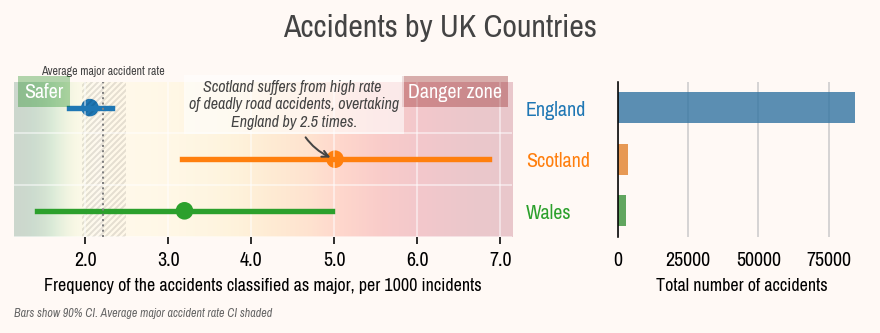

In [26]:
ax,_ = double_plot(df.dropna(), 'country', sorter=None,
                title='Accidents by UK Countries', vr=0.4, CI=CI)

annotation=\
"""Scotland suffers from high rate 
of deadly road accidents, overtaking
England by 2.5 times."""

annotate(ax, annotation, (0.005, 1), (-40,30))

plt.show()

### Local Areas
We will take a look at the different parts of the country at a more granular level, by __county__. There are more than 200 counties in Great Britain, and they are very different by population, density, traffic levels, urbanisation, climate etc. Some of them do not experience a road accident with fatalities in the year at all.

As our investigation aims to find targets for the activity reducing serious crashes, I won’t be interested in the regions with low accident numbers. In my further analysis, I will pick only countries with a higher than average major accident rate. There are 77 counties like this. Let us plot them all.

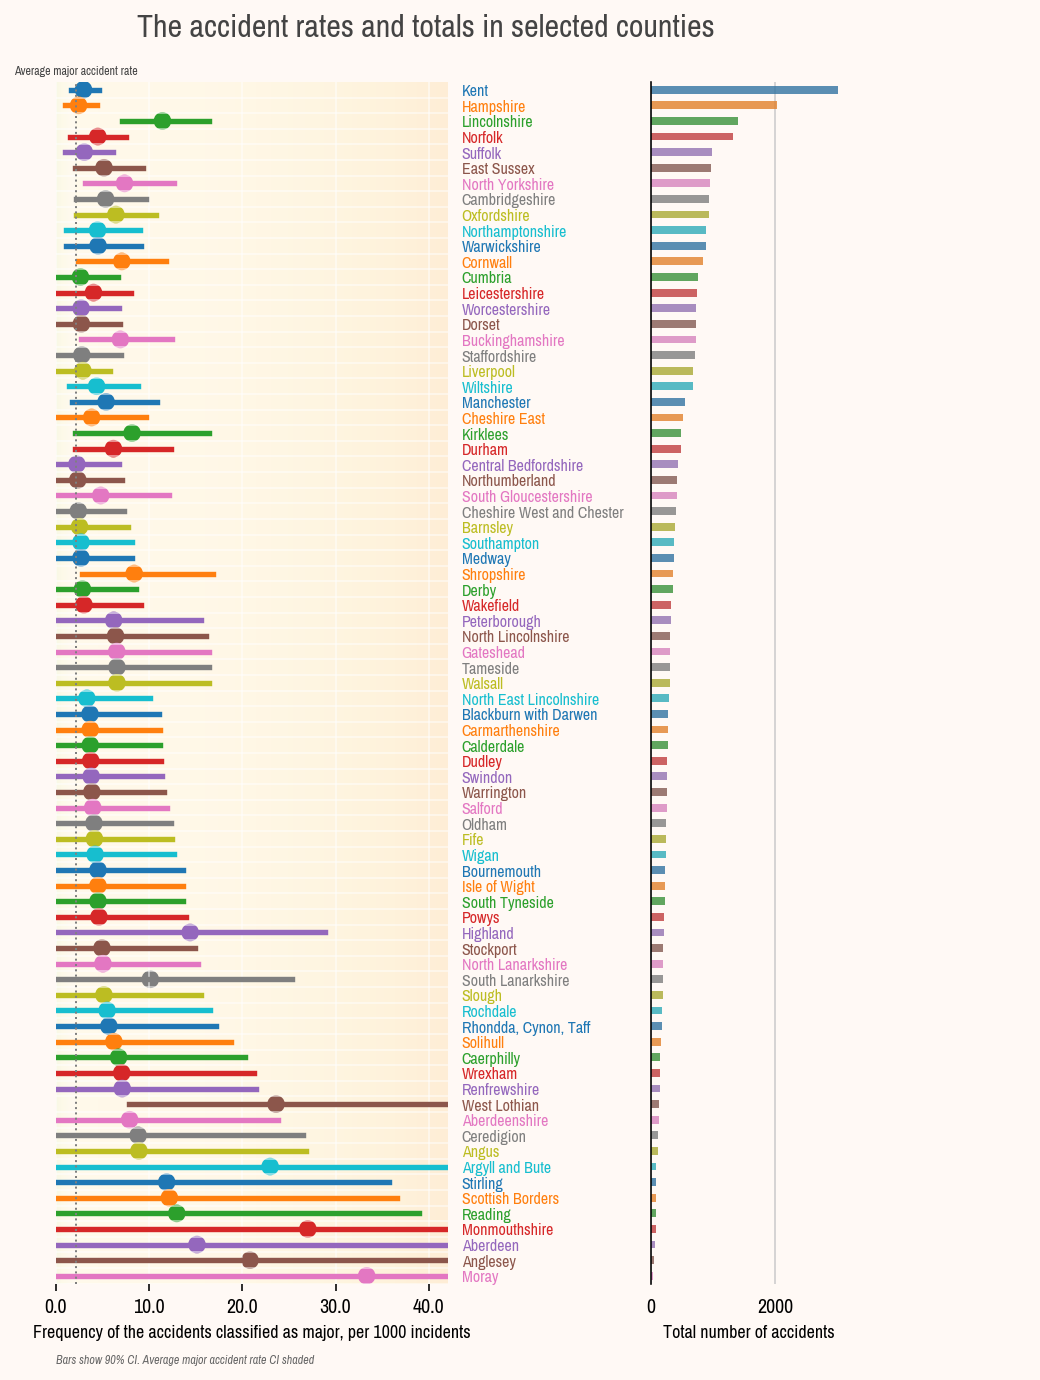

In [27]:
counties_of_interest = df.groupby('county').agg(['mean', 'count'])['major_accident']\
    .query('mean > {}'.format(baseline_rate)).sort_values('count', ascending=False).index.tolist()

df_filtered = df[df.county.isin(counties_of_interest)]

ax, _ = double_plot(df_filtered, 'county', sorter=counties_of_interest,
                color_labels=True, bar_width=0.5, vr=0.11, n_boot=5000,
                title='The accident rates and totals in selected counties')
ax.set_xlim([-0.00, 0.042])
ax.yaxis.set_tick_params(which='major', labelsize=8)

plt.show()

xmin=[l.get_xdata()[0] for l in ax.lines[0:-1]]

Obviously, for many counties, especially those with low total numbers, data is statistically inconclusive — mind the confidence interval bars. However, there are some notable cases with statistically higher rates of fatal accidents. The next figure will show them separately.

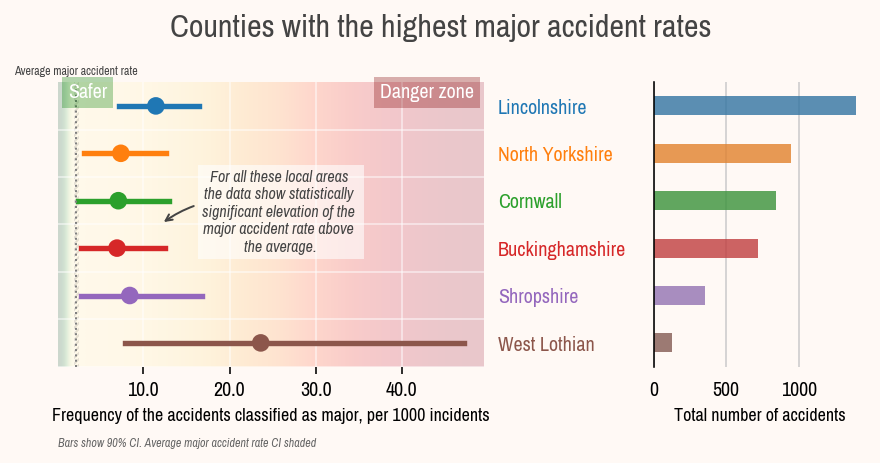

In [28]:
xmins = pd.DataFrame(dict(county=counties_of_interest, xmin=xmin))

counties_of_interest_2 = xmins[xmins['xmin']>baseline_rate]['county'].tolist()

ax, _ = double_plot(df_filtered, 'county', sorter=counties_of_interest_2,
                color_labels=True, bar_width=0.4, vr=0.35, CI=CI, n_boot=2000,
                title='Counties with the highest major accident rates')

annotation=\
"""For all these local areas 
the data show statistically 
significant elevation of the 
major accident rate above 
the average."""
annotate(ax, annotation, (0.012, 2.5), (120,-30))

plt.show()

### High Fatality Local Areas

In [29]:
df[df['county'].isin(counties_of_interest_2)].groupby('county')\
    .agg({'major_accident': ['count', 'sum', lambda x: np.mean(x)*1000]})['major_accident']\
    .rename({'count': 'Total accidents', 
             'sum': 'Major accidents', 
             '<lambda_0>': 'Major accident rate'}, axis=1)\
    .sort_values('Total accidents', ascending=False)\
    .style.format(formatter={"Major accident rate": "{:.1f}"})

,Total accidents,Major accidents,Major accident rate
county,,,
Lincolnshire,1397,16,11.5
North Yorkshire,947,7,7.4
Cornwall,845,6,7.1
Buckinghamshire,720,5,6.9
Shropshire,356,3,8.4
West Lothian,127,3,23.6


(Compare rates in the table above to the average rate of the major accidents of 2.2)

## Talk the Action
### Executive Summary 

This report identified a few factors that drive the number of major (high-fatality) road accidents higher. I will summarise the most important of them here:
- __Speed limits__: The major accidents happen most often on high-speed single carriageway parts of the road net (A-roads). For different parts of the network, there can be different ways to address the issue, including reducing allowed speed in the most dangerous parts, converting the road into a dual carriageway, adding other safety features.
- __Wet roads__: Road surface conditions impair safety in a great way. While we do not control the weather, we can address the problem through speed limits, road design, education.
- __Night driving__: Nighttime fatal crashes might be prevented — data shows that artificial lighting improves outcomes in a car accident significantly. While full illumination of the road network is inviable, the problem can be addressed on a case-by-case basis, installing lighting at most dangerous stretches. The contribution of behavioural factors, i.e. drink driving, fatigued driving etc., requires additional data.
- __Weekend__: The frequency of high-fatality accidents on weekends is higher on Saturdays and Sundays. This requires additional research within the same scope as in the previous point.
- __Months__: August and December are the most months of the year, and, probably, it is the best time to double efforts at the education of drivers on safe driving and roll-up high-visibility police operations addressing lousy driving behaviour.
- __Counties of interest__: We identified six counties where road safety requires extra attention: Lincolnshire, North Yorkshire, Cornwall, Buckinghamshire, Shropshire, West Lothian. All of the above apply to them with the need to double the efforts.

## About Me

I’m Eugene Kutilov, and I’m absolutely excited about all things data. I was born in Russia (you guessed it right, English is not my first language), got my Masters in applied physics, worked (that’s a twist!) many years in tech journalistic and marketing, and, finally, moved to Australia.

After many years of talking about technologies, I embraced my inner researcher (applied physics, mind you) and started to make technologies and data myself. Thanks to Daacamp, I do R, Python, SQL, as well as GCS, some AWS, Datawrapper, Tableau, Alteryx, Tensorflow and so on (alas, mostly as a hobby, until my dream job come along).

Good luck and have fun here everyone!

In [30]:
printmd("---\n<font color='gray'>_This version rendered {}_.</font>"\
        .format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

---
<font color='gray'>_This version rendered 2021-12-08 11:54:39_.</font>